<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%87%BC%ED%95%91%EB%AA%B0_%EC%A7%80%EC%A0%90%EB%B3%84_%EB%A7%A4%EC%B6%9C%EC%95%A1_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


쇼핑몰 지점별 매출액 예측 경진대회 https://dacon.io/competitions/official/235942/overview/description

# module

In [ ]:
!pip install catboost

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# data lode

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# EDA

In [3]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [5]:
train.isna().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [17]:
train.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6.255000e+03
mean,3128.000000,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,1.047619e+06
std,1805.807299,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,5.654362e+05
min,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,2.099862e+05
25%,1564.500000,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,5.538695e+05
50%,3128.000000,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,9.604761e+05
75%,4691.500000,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,1.421209e+06
max,6255.000000,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,3.818686e+06


In [21]:
train.columns

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

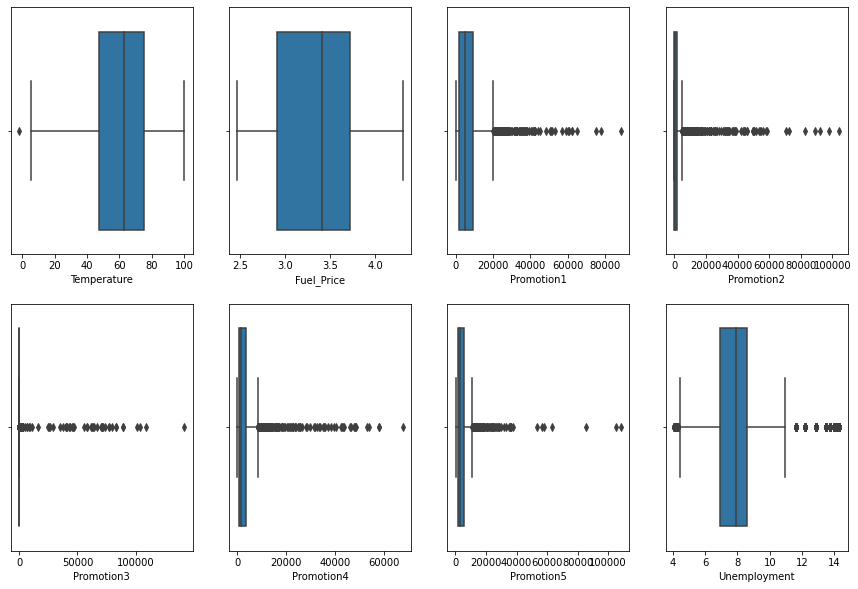

In [29]:
pltbox_list = ['Temperature', 'Fuel_Price', 'Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment']
plt.figure(figsize=(15,10))
for i in range(len(pltbox_list)):
    plt.subplot(2,4,i+1)
    sns.boxplot(train[pltbox_list[i]])
plt.show()

In [6]:
test.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
0,1,1,05/10/2012,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,6.573,False
1,2,1,12/10/2012,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,6.573,False
2,3,1,19/10/2012,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,6.573,False
3,4,1,26/10/2012,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False
4,5,2,05/10/2012,70.27,3.617,6037.76,NaN,10.04,3027.37,3853.40,6.170,False


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    178 non-null    float64
 6   Promotion2    45 non-null     float64
 7   Promotion3    161 non-null    float64
 8   Promotion4    146 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB


In [9]:
test.isna().sum()

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
dtype: int64

## Store

In [ ]:
train.Store.value_counts()

In [ ]:
test.Store.value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


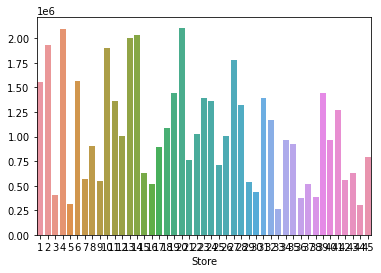

In [61]:
store_sales = train.groupby('Store').mean()['Weekly_Sales']
sns.barplot(store_sales.index,store_sales.values)
plt.show()

## Date(to_datetime)

In [34]:
train['Week'] = pd.to_datetime(train.Date, format='%d/%m/%Y').dt.week
train['Year'] = pd.to_datetime(train.Date, format='%d/%m/%Y').dt.year
train['Month'] = pd.to_datetime(train.Date, format='%d/%m/%Y').dt.month
test['Week'] = pd.to_datetime(test.Date, format='%d/%m/%Y').dt.week
test['Year'] = pd.to_datetime(test.Date, format='%d/%m/%Y').dt.year
test['Month'] = pd.to_datetime(test.Date, format='%d/%m/%Y').dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [32]:
train.Year.value_counts()

2011    2340
2010    2160
2012    1755
Name: Year, dtype: int64

In [33]:
test.Year.value_counts()

2012    180
Name: Year, dtype: int64

In [36]:
train.Month.value_counts()

4     630
7     630
3     585
6     585
8     585
9     585
2     540
5     540
12    450
10    405
11    360
1     360
Name: Month, dtype: int64

In [37]:
test.Month.value_counts()

10    180
Name: Month, dtype: int64

In [ ]:
train.Week.value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


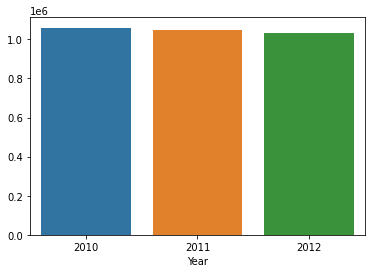

In [50]:
year_slaes = train.groupby('Year').mean()['Weekly_Sales']
sns.barplot(year_slaes.index,year_slaes.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


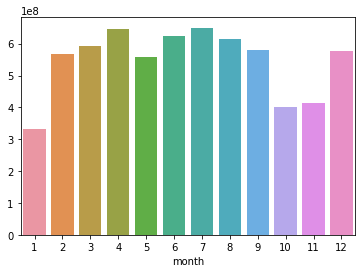

In [47]:
month_slaes = train.groupby('Month').sum()['Weekly_Sales']
sns.barplot(month_slaes.index,month_slaes.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


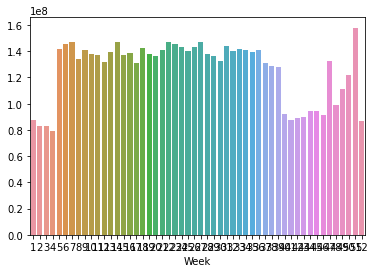

In [48]:
week_slaes = train.groupby('Week').sum()['Weekly_Sales']
sns.barplot(week_slaes.index,week_slaes.values)
plt.show()

## Temperature

In [51]:
train[train['Temperature'] == train['Temperature'].min()]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Year,month,Month
886,887,7,04/02/2011,-2.06,3.011,NaN,NaN,NaN,NaN,NaN,8.818,False,558027.77,5,2011,2,2


In [52]:
train[(train['Store']==7) & (train['Month']==2)]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Year,month,Month
834,835,7,05/02/2010,10.53,2.580,NaN,NaN,NaN,NaN,NaN,9.014,False,496725.44,5,2010,2,2
835,836,7,12/02/2010,25.90,2.572,NaN,NaN,NaN,NaN,NaN,9.014,True,524104.92,6,2010,2,2
836,837,7,19/02/2010,27.28,2.550,NaN,NaN,NaN,NaN,NaN,9.014,False,506760.54,7,2010,2,2
837,838,7,26/02/2010,24.91,2.586,NaN,NaN,NaN,NaN,NaN,9.014,False,496083.24,8,2010,2,2
886,887,7,04/02/2011,-2.06,3.011,NaN,NaN,NaN,NaN,NaN,8.818,False,558027.77,5,2011,2,2
887,888,7,11/02/2011,10.24,3.037,NaN,NaN,NaN,NaN,NaN,8.818,True,559903.13,6,2011,2,2
888,889,7,18/02/2011,17.30,3.051,NaN,NaN,NaN,NaN,NaN,8.818,False,572387.47,7,2011,2,2
889,890,7,25/02/2011,17.46,3.101,NaN,NaN,NaN,NaN,NaN,8.818,False,546690.84,8,2011,2,2
938,939,7,03/02/2012,22.20,3.031,56917.70,1839.82,4.53,16241.73,2414.97,8.256,False,580453.32,5,2012,2,2
939,940,7,10/02/2012,18.79,3.103,13100.37,3096.60,1.73,4854.70,6266.04,8.256,True,563460.77,6,2012,2,2


In [53]:
train.loc[train['Temperature'] == train['Temperature'].min(), 'Temperature'] = train[(train['Store']==7) & (train['Month']==2)]['Temperature'].mean()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


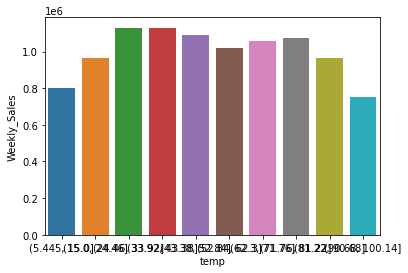

In [59]:
train_temp = train.copy()
train_temp['temp'] = pd.cut(train_temp['Temperature'], 10)
train_temp_g = train_temp.groupby('temp').mean()['Weekly_Sales']

sns.barplot(train_temp_g.index, train_temp_g)
plt.show()

## Fuel_Price

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


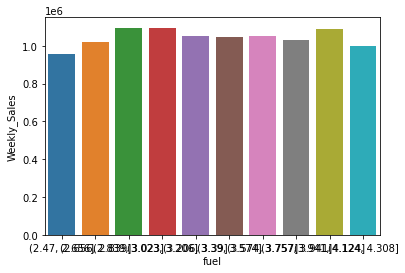

In [62]:
train_temp = train.copy()
train_temp['fuel'] = pd.cut(train_temp['Fuel_Price'], 10)
train_temp_g = train_temp.groupby('fuel').mean()['Weekly_Sales']

sns.barplot(train_temp_g.index, train_temp_g)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


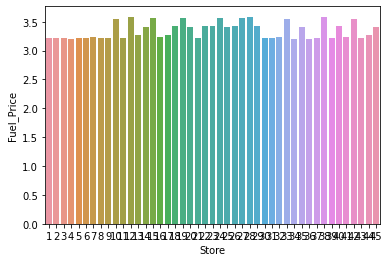

In [68]:
train_g = train.groupby('Store').mean()['Fuel_Price']
sns.barplot(train_g.index, train_g)
plt.show()

## Promotion

In [69]:
train.groupby('Year').mean()['Promotion1']

Year
2010            NaN
2011    4312.248588
2012    7731.825086
Name: Promotion1, dtype: float64

In [70]:
train.groupby('Year').mean()['Promotion2']

Year
2010            NaN
2011    7585.530273
2012    2343.322494
Name: Promotion2, dtype: float64

In [71]:
train.groupby('Year').mean()['Promotion3']

Year
2010            NaN
2011    7805.060702
2012      56.739274
Name: Promotion3, dtype: float64

In [72]:
train.groupby('Year').mean()['Promotion4']

Year
2010            NaN
2011    1507.795232
2012    3855.776823
Name: Promotion4, dtype: float64

In [73]:
train.groupby('Year').mean()['Promotion5']

Year
2010            NaN
2011    6128.216139
2012    4188.896154
Name: Promotion5, dtype: float64

In [82]:
train_pro = train.copy()
train_pro['pro'] = train.loc[:,'Promotion1':'Promotion5'].sum(axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


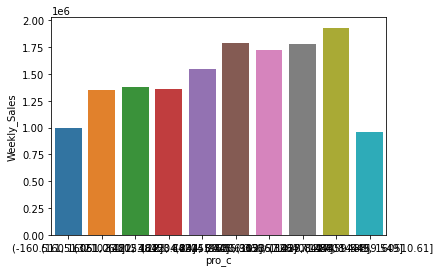

In [84]:
train_pro['pro_c'] = pd.cut(train_pro['pro'],10)
train_pro_g = train_pro.groupby('pro_c').mean()['Weekly_Sales']
sns.barplot(train_pro_g.index, train_pro_g)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

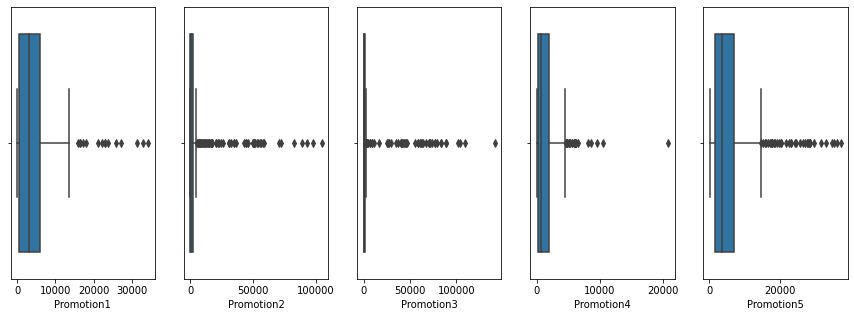

In [88]:
train_2011 = train[train['Year'] == 2011]
pltbox_list = ['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']
plt.figure(figsize=(15,5))
for i in range(len(pltbox_list)):
    plt.subplot(1,5,i+1)
    sns.boxplot(train_2011[pltbox_list[i]])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

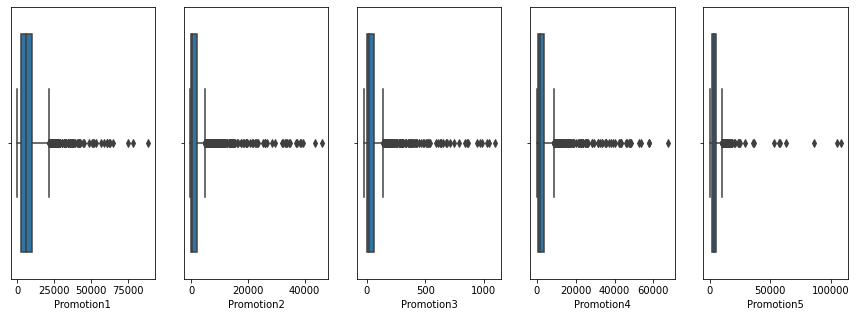

In [103]:
train_2012 = train[train['Year'] == 2012]
pltbox_list = ['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']
plt.figure(figsize=(15,5))
for i in range(len(pltbox_list)):
    plt.subplot(1,5,i+1)
    sns.boxplot(train_2012[pltbox_list[i]])
plt.show()

In [115]:
train['pro'] = train.loc[:,'Promotion1':'Promotion5'].sum(axis=1)
test['pro'] = test.loc[:,'Promotion1':'Promotion5'].sum(axis=1)

## Unemployment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


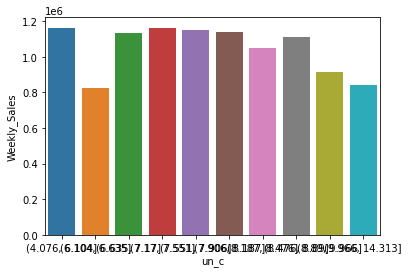

In [90]:
train_un = train.copy()
train_pro['un_c'] = pd.qcut(train_pro['Unemployment'],10)
train_pro_g = train_pro.groupby('un_c').mean()['Weekly_Sales']
sns.barplot(train_pro_g.index, train_pro_g)
plt.show()

## IsHoliday

In [91]:
train.IsHoliday.value_counts()

False    5805
True      450
Name: IsHoliday, dtype: int64

In [92]:
test.IsHoliday.value_counts()

False    180
Name: IsHoliday, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


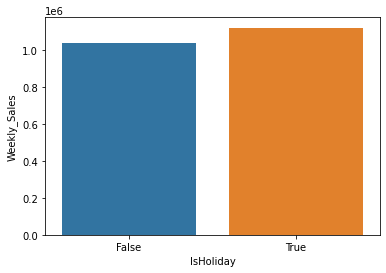

In [94]:
train_ho_g = train.groupby('IsHoliday').mean()['Weekly_Sales']
sns.barplot(train_ho_g.index, train_ho_g)
plt.show()

In [97]:
lae = LabelEncoder()
train['IsHoliday'] = lae.fit_transform(train[['IsHoliday']])
test['IsHoliday'] = lae.transform(test[['IsHoliday']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Store_Year

In [106]:
import warnings
warnings.filterwarnings('ignore')

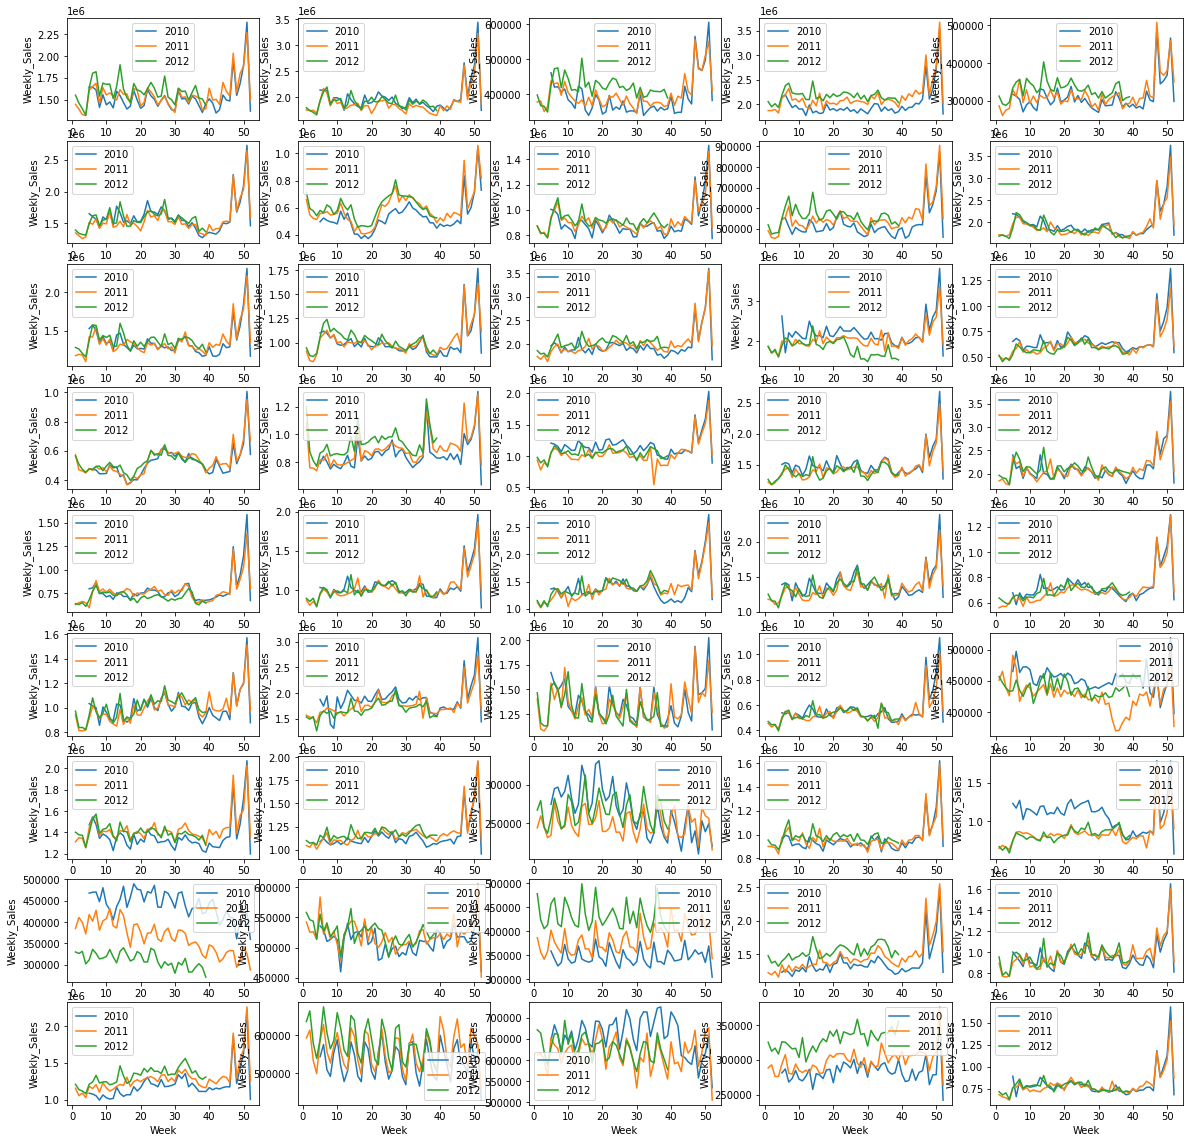

In [107]:
plt.figure(figsize=(20,20))
for i in range(1,46):
    plt.subplot(9,5,i)
    for j in [2010,2011,2012]:
        train_plt = train[(train['Store'] == i) & (train['Year'] == j)]
        sns.lineplot(train_plt['Week'], train_plt['Weekly_Sales'], label=j)
plt.legend()
plt.show()

## Standard, MinMax

In [112]:
sds, mms = StandardScaler(), MinMaxScaler()

In [117]:
train_d = train.copy()

In [118]:
train_d.columns

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Week', 'Year', 'month', 'Month', 'pro'],
      dtype='object')

In [119]:
sds, mms = StandardScaler(), MinMaxScaler()
sms = Pipeline([('sds',sds), ('mms', mms)])
def sms_t(x):
    train[x] = sms.fit_transform(train[[x]])
    test[x] = sms.fit_transform(test[[x]])
for i in ['Temperature', 'Fuel_Price', 'Unemployment','pro']:
    sms_t(i)

In [120]:
train.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Year,month,Month,pro
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000,6255.000000,6255.000000
mean,3128.000000,23.000000,0.582479,0.475147,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,0.386111,0.071942,1.047619e+06,25.366906,2010.935252,6.345324,6.345324,0.038773
std,1805.807299,12.988211,0.196774,0.248020,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,0.183165,0.258413,5.654362e+05,14.073468,0.788547,3.227195,3.227195,0.089965
min,1.000000,1.000000,0.000000,0.000000,0.270000,-265.760000,-29.100000,0.410000,135.160000,0.000000,0.000000,2.099862e+05,1.000000,2010.000000,1.000000,1.000000,0.000000
25%,1564.500000,12.000000,0.440063,0.242375,1844.295000,39.755000,4.700000,499.895000,1742.305000,0.277403,0.000000,5.538695e+05,13.000000,2010.000000,4.000000,4.000000,0.000000
50%,3128.000000,23.000000,0.604440,0.512527,5221.140000,205.410000,24.600000,1532.630000,3226.410000,0.374072,0.000000,9.604761e+05,25.000000,2011.000000,6.000000,6.000000,0.000000
75%,4691.500000,34.000000,0.736575,0.680828,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,0.444021,0.000000,1.421209e+06,37.000000,2012.000000,9.000000,9.000000,0.038599
max,6255.000000,45.000000,1.000000,1.000000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,1.000000,1.000000,3.818686e+06,52.000000,2012.000000,12.000000,12.000000,1.000000


# modeling

In [123]:
knr = KNeighborsRegressor()
svr = SVR()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
cat = CatBoostRegressor(verbose=0)
lgbm = LGBMRegressor()

In [128]:
train.columns
dd_train = train[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Week', 'Year', 'Month', 'pro']]
ee_train = train['Weekly_Sales']

In [129]:
dd_train = dd_train.fillna(0)

In [135]:
dd_train[dd_train['Year'] != 2012]

,Store,Temperature,Fuel_Price,Unemployment,IsHoliday,Weekly_Sales,Week,Year,Month,pro
0,1,0.388689,0.054466,0.393611,0,1643690.90,5,2010,2,0.000000
1,1,0.348520,0.041394,0.393611,1,1641957.44,6,2010,2,0.000000
2,1,0.363531,0.022876,0.393611,0,1611968.17,7,2010,2,0.000000
3,1,0.434355,0.048475,0.393611,0,1409727.59,8,2010,2,0.000000
4,1,0.432981,0.083333,0.393611,0,1554806.68,9,2010,3,0.000000
...,...,...,...,...,...,...,...,...,...,...
6211,45,0.471987,0.533769,0.434349,0,875699.81,48,2011,12,0.175134
6212,45,0.433721,0.513617,0.434349,0,957155.31,49,2011,12,0.114155
6213,45,0.363531,0.512527,0.434349,0,1078905.68,50,2011,12,0.056368
6214,45,0.388266,0.499455,0.434349,0,1521957.99,51,2011,12,0.036452


In [136]:
dd_train['Month'] <=9

0       True
1       True
2       True
3       True
4       True
        ... 
6250    True
6251    True
6252    True
6253    True
6254    True
Name: Month, Length: 6255, dtype: bool

In [144]:
for i in range(1,2):
    dd_train_1 = dd_train[(dd_train['Month'] <=9) & (dd_train['Year'] != 2012)]
    dd_train_2 = dd_train[(dd_train['Month'] < 9) & (dd_train['Year'] == 2012)]
    dd_train_3 = pd.concat([dd_train_1, dd_train_2], axis=0)
    dd_train_4 = dd_train[(dd_train['Month']  == 9) & (dd_train['Year'] == 2012)]

    ee_train_1 = train[(train['Month'] <=9) & (train['Year']!= 2012)]
    ee_train_2 = train[(train['Month'] < 9) & (train['Year'] == 2012)]
    ee_train_3 = pd.concat([ee_train_1, ee_train_2], axis=0)
    ee_train_4 = train[(train['Month'] == 9) & (train['Year'] == 2012)]
                          
    model = xgb.fit(dd_train_3, ee_train_3['Weekly_Sales'])
    pre = model.predict(dd_train_4)
    print(mean_squared_error(ee_train_4['Weekly_Sales'] ,pre)**0.5)

[08:55:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3960.178939274902


In [142]:
ee_train_3

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,...,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Year,month,Month,pro
0,1.0,1.0,05/02/2010,0.388689,0.054466,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,12/02/2010,0.348520,0.041394,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1.0,19/02/2010,0.363531,0.022876,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,1.0,26/02/2010,0.434355,0.048475,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,05/03/2010,0.432981,0.083333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11142.69,2768.32,0.450078,0.0,725729.51,31.0,2012.0,8.0,8.0,0.241863
6247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2593.93,1890.59,0.450078,0.0,733037.32,32.0,2012.0,8.0,8.0,0.139939
6248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1630.50,3794.22,0.450078,0.0,722496.93,33.0,2012.0,8.0,8.0,0.056624
6249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5518.07,2291.97,0.450078,0.0,718232.26,34.0,2012.0,8.0,8.0,0.098602
